In [530]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from qutip import *
import scipy.optimize
from functools import partial
import os

font = {'size'   : 30}

mpl.rc('font', **font)
mpl.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,nicefrac}')
plt.rcParams["figure.figsize"]= 10, 8
mpl.rcParams['lines.linewidth'] = 2
props = dict(boxstyle='round', ec='black', fc='white', alpha=0.5)

deltaD = 0.5
rho = 2/deltaD
nj = rho*deltaD

## Denominators

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{D}{2} - \frac{U}{2} + \frac{K}{4}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}, \quad d_3 = \omega - \frac{D}{2} + \frac{K}{4}
$$

In [ ]:
def den(w, D, U, J, K):
    d0 = w - D/2 - U/2 + K/4
    d1 = w - D/2 + U/2 + J/4
    d2 = w - D/2  + J/4
    d3 = w - D/2  + K/4
    return np.array([d0, d1, d2, d3])

## RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 
$$
\Delta U = 4V^2 n_j\left(\frac{1}{d_0} - \frac{1}{d_1}\right) - \frac{n_j}{2}\left(\frac{J^2}{d_2} - \frac{K^2}{d_3}\right),\\
\Delta V = -\frac{3n_j V}{8}\left[J\left(\frac{1}{d_2} + \frac{1}{d_1}\right) + K \left(\frac{1}{d_3} + \frac{1}{d_0}\right)\right],\\
\Delta J = -\frac{n_j J^2}{d_2}, \quad\quad\Delta K = -\frac{n_j K^2}{d_3}
$$

In [ ]:
def rg1(w, D, U, V, J):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2) if d1 < 0 else 0
    deltaV = -3*nj*V*J*(1/d1 + 1/d2)/8 if d1 < 0 else 0
    deltaJ = -nj*J**2/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

def rg2(w, D, U, V, K):
    J = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) + nj*K**2/(2*d3) if d0 < 0 else 0
    deltaV = -3*nj*V*K*(1/d0 + 1/d3)/8 if d0 < 0 else 0
    deltaK = -nj*K**2/d3

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    K = 0 if (K + deltaK) * K <= 0 else K + deltaK

    return U, V, K

def rg3(w, D, U, V, J):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2)
    deltaV = -3*nj*V*J*(1/d1 + 1/d2)/8
    deltaJ = -nj*J**2/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [ ]:
def complete_RG(w, D0, U0, V0, J0):
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg1(w, D, U[-1], V[-1], J[-1])
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0)
        if d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

def complete_RG2(w, D0, U0, V0, K0):
    U = [U0]
    V = [V0]
    K = [K0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, K_j = rg2(w, D, U[-1], V[-1], K[-1])
        U.append(U_j)
        V.append(V_j)
        K.append(K_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], 0, K[-1])
        if d3 >= 0:
            break
    return np.array(E), np.array(U), np.array(V), np.array(K)

def complete_RG3(w, D0, U0, V0, J0):
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg3(w, D, U[-1], V[-1], J[-1])
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0)
        if d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

## Positive $U$ regime

In [ ]:
D0 = 10
w = -D0/2
U0 = D0/10
V0 = D0/100
J0 = D0/200
E, U, V, J = complete_RG(w, D0, U0, V0, J0)
steps = E/D0
fig, ax = plt.subplots(1, 3, figsize=(30,8))
ax[0].plot(steps, U/D0)
ax[0].set_xlabel(r"\% of RG completed")
ax[0].set_ylabel(r"$U/D_0$")
ax[1].plot(steps, V/D0)
ax[1].set_xlabel(r"\% of RG completed")
ax[1].set_ylabel(r"$V/D_0$")
ax[1].set_yscale("log")
ax[2].plot(steps, J/D0)
ax[2].set_xlabel(r"\% of RG completed")
ax[2].set_ylabel(r"$J/D_0$")
ax[2].set_yscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
ax[1].text(0.5, 0.8, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
plt.tight_layout()
# plt.savefig("U_irr,U>0.pdf", bbox_inches='tight')
U0 = D0/10
V0 = D0/200
J0 = D0/100
E, U, V, J = complete_RG(w, D0, U0, V0, J0)
steps = E/D0
fig, ax = plt.subplots(1, 3, figsize=(30,8))
ax[0].plot(steps, U/D0)
ax[0].set_xlabel(r"\% of RG completed")
ax[0].set_ylabel(r"$U/D_0$")
ax[0].set_yscale("log")
ax[1].plot(steps, V/D0)
ax[1].set_xlabel(r"\% of RG completed")
ax[1].set_ylabel(r"$V/D_0$")
ax[1].set_yscale("log")
ax[2].plot(steps, J/D0)
ax[2].set_xlabel(r"\% of RG completed")
ax[2].set_ylabel(r"$J/D_0$")
ax[2].set_yscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
ax[1].text(0.5, 0.8, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
plt.tight_layout()
# plt.savefig("U_rel,U>0.pdf", bbox_inches='tight')

In [ ]:
Drange = 10**np.linspace(1, 4, 6)
U0 = 0.1
V0 = 0.1
J0 = 0.05
plt.figure(figsize=(12,12))
for D0 in Drange:
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    plt.scatter(D0, V[-1], s=100, marker='o', color='r')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$V^*$")
plt.xlabel(r"$D_0$")
txt = '\n'.join([r"$\frac{{U_0}}{{V_0}} = {}$".format(U0/V0), r"$\frac{{J_0}}{{V_0}} = {}$".format(J0/V0)])
plt.text(0.75, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Vstar_vs_D_largeV.pdf", bbox_inches='tight')
plt.show()

V0 = 0.1
J0 = 0.25
plt.figure(figsize=(12,12))
for D0 in Drange:
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    plt.scatter(D0, V[-1], s=100, marker='o', color='r')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$V^*$")
plt.xlabel(r"$D_0$")
txt = '\n'.join([r"$\frac{{U_0}}{{V_0}} = {}$".format(U0/V0), r"$\frac{{J_0}}{{V_0}} = {}$".format(J0/V0)])
plt.text(0.75, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Vstar_vs_D_smallV.pdf", bbox_inches='tight')

## Get phase map of relevance of $U$ in the $J-V$ plane

In [ ]:
def get_rel_V(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-3, 1, 100):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            rel.append(V0/D0)
        else:
            if V0 == 1e-3:
                print ("Outlier:", J0/D0)
            irr.append(V0/D0)
    return rel, irr

D0 = 100
w = -D0/2
U0 = 0.5
J0_range = 10**np.linspace(-3, 1, 100)
results = list(tqdm(Pool().imap(get_rel_V, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$U$ relevant")
plt.plot([],[],color='b', label=r"$U$ irrelevant")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_0/D_0$")
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Get phase map of $J^*/V^*$ in $J$ vs $V$

In [ ]:
def get_rel_JbyV(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-2.5, 0, 50)*J0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if J[-1] > V[-1]:
            rel.append(V0/D0)
        else:
            irr.append(V0/D0)
    return rel, irr

D0 = 10000
w = -D0/2
U0 = D0/10
J0_range = 10**np.linspace(-2.5, -1, 50)*D0
results = list(tqdm(Pool().imap(get_rel_JbyV, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$J^* > V^*$")
plt.plot([],[],color='b', label=r"$J^* < V^*$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_0/D_0$")
# plt.plot(J0_range/D0 + 0.5*10**(-3), J0_range/D0, ls='--')
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Get phase map of relevance of $U$ in the $J-U$ plane

In [ ]:
def get_rel_U(J0):
    rel = []
    irr = []
    for U0 in 10**np.linspace(-4, 3, 300):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            rel.append(U0/D0)
        else:
            if U0 == 1e-4:
                print ("Outlier:", J0/D0)
            irr.append(U0/D0)
    return rel, irr

D0 = 100
w = -D0/2
V0 = 0.1
J0_range = 10**np.linspace(-3, 1, 100)
results = list(tqdm(Pool(40).imap(get_rel_U, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$U$ relevant")
plt.plot([],[],color='b', label=r"$U$ irrelevant")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$U_0/D_0$")
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$V_0/D_0 = {}$".format(V0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("UvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Get critical $U$ at partition for given $J$ over range of $J$

In [ ]:
def get_Uc(J0):
    rel = []
    irr = []
    for U0 in 10**np.linspace(-6, 3, 200):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            continue
        else:
            return U0/D0

D0 = 100
w = -D0
V0 = 0.2
J0_range = 10**np.linspace(-3.5, 1, 100)
Uc = list(tqdm(Pool(40).imap(get_Uc, J0_range), total=len(J0_range)))
plt.scatter(J0_range/D0, Uc, color='black', marker='.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$U_c/D_0$")
plt.text(0.75, 0.2, r"$V_0/D_0 = {}$".format(V0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("UcvsJ.pdf", bbox_inches='tight')
plt.show()

## Get critical $V$ at partition for given $J$ over range of $J$

In [ ]:
def get_Vc(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-3, 1, 100):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            continue
        else:
            return V0/D0

D0 = 100
w = -D0
U0 = 1
J0_range = 10**np.linspace(-3, 1, 200)
Vc = list(tqdm(Pool(40).imap(get_Vc, J0_range), total=len(J0_range)))
plt.scatter(J0_range/D0, Vc, color='black', marker='.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_c/D_0$")
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VcvsJ.pdf", bbox_inches='tight')
plt.show()

In [ ]:
def get_Jc(D0):
    U0 = D0
    V0 = D0/100
    J0 = V0/10000
    w = -D0
    acc = -5
    deltaj = 1
    while np.log10(abs(deltaj)) > acc:
#         print (np.log10(abs(deltaj)))
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if J[-1]/V[-1] > 1:
            deltaj /= -10
#             print (deltaj)
        J0 += deltaj
    
    print ((J0 - deltaj)/D0)
    return (J0 - deltaj)/D0

U0 = 1
V0 = 0.1
Drange = 10**np.linspace(1, 5, 5)
Jc = np.array(list(tqdm(Pool(1).imap(get_Jc, Drange), total=len(Drange))))
plt.scatter(Drange, Jc)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$D_0$")
plt.ylabel(r"$J_c/D_0$")
plt.text(0.8, 0.8, r"$U_0/V_0 = {:.2f}$".format(U0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("Jc_vs_D0.pdf", bbox_inches='tight')

## Get $c_s, c_c$ that characterise ground state, for multiple $J$

In [ ]:
def get_cs(J0):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    N = E[-1]/deltaD
    v = V[-1]
    j = J[-1]
    u = U[-1]
    gamma = (3*j/8 + u/4)/v
    c1sq = (1 + gamma/sqrt(gamma**2 + 4))/2
    c2sq = (1 - gamma/sqrt(gamma**2 + 4))/2
    return (c1sq, c2sq)

In [ ]:
D0 = 100
w = -D0/2
V0 = D0/100
J0_range = 10**np.linspace(-2.5, 0, 100)*D0
fig, ax = plt.subplots(1,2, figsize=(25, 10))
i = 0
for U0 in [D0/1000, D0/10]:
    results = list(tqdm(Pool().imap(get_cs, J0_range), total=len(J0_range)))
    c1sq_arr = [c1 for c1,c2 in results]
    c2sq_arr = [c2 for c1,c2 in results]

    ax[i].scatter(J0_range/D0, c1sq_arr, color='r', label=r"$c_s^2$")
    ax[i].scatter(J0_range/D0, c2sq_arr, color='b', label=r"$c_c^2$")

    ax[i].set_xscale("log")

    ax[i].set_xlabel(r"$J_0/D_0$")
    ax[i].set_ylabel(r"$c_s^2$, $c_c^2$")

    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0)])
    ax[i].text(0.45, 0.5, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
    ax[i].axhline(1,0,1, ls="--", color='black', label=r"$c^2=1$")
    ax[i].axhline(0,0,1, ls="--", color='green', label=r"$c^2=0$")
    ax[i].legend()
    i += 1

plt.tight_layout()
# plt.savefig("coeffs_vs_J.pdf", bbox_inches='tight')

In [ ]:
D0 = 100
w = -D0/2
V0 = D0/100
J0_range = 10**np.linspace(-2.5, 0, 100)*D0
i = 0
U0 = D0/1000
results = list(tqdm(Pool().imap(get_cs, J0_range), total=len(J0_range)))
c1sq_arr = [c1 for c1,c2 in results]
c2sq_arr = [c2 for c1,c2 in results]

plt.figure(figsize=(10,7))
plt.scatter(J0_range/D0, c1sq_arr, color='r', label=r"$c_s^2$")
plt.scatter(J0_range/D0, c2sq_arr, color='b', label=r"$c_c^2$")
plt.xscale("log")
plt.axis('off')
plt.axhline(1,0,1, ls="--", color='white', label=r"$c^2=1$")
plt.axhline(0,0,1, ls="--", color='green', label=r"$c^2=0$")
# plt.savefig("research.svg", bbox_inches='tight')

## $c_s$ $c_c$ under increase of $D_0$

In [ ]:
Drange = 10**np.linspace(0.5, 4, 5)
U0 = 0.1
V0 = 0.1
J0 = 0.05
for D0 in tqdm(Drange):
    w = -D0/2
    c1sq, c2sq = get_cs(J0)
    plt.scatter(D0, c1sq, s=100, color='r')
    plt.scatter(D0, c2sq, s=100, color='b', marker='^')

plt.scatter([], [], s=100, color='r', label=r'$c_s^2$')
plt.scatter([], [], s=100, color='b', label=r'$c_c^2$', marker='^')
plt.axhline(1, 0, 1, ls='--', color='r', label=r'$c_s^2=1$')
plt.axhline(0, 0, 1, ls='--', color='b', label=r'$c_c^2=0$')
plt.legend(loc=5).get_frame().set_edgecolor('black')
plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.text(0.45, 0.5, r"$\frac{{J_0}}{{V_0}}={}$".format(J0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xscale("log")
plt.savefig("coeffs_vs_D_largeV.pdf", bbox_inches='tight')
plt.show()

U0 = 0.1
V0 = 0.1
J0 = 0.25
for D0 in tqdm(Drange):
    w = -D0/2
    c1sq, c2sq = get_cs(J0)
    plt.scatter(D0, c1sq, s=100, color='r')
    plt.scatter(D0, c2sq, s=100, color='b', marker='^')

plt.scatter([], [], color='r', s=100, label=r'$c_s^2$')
plt.scatter([], [], color='b', s=100, label=r'$c_c^2$', marker='^')
plt.axhline(1, 0, 1, ls='--', color='r', label=r'$c_s^2=1$')
plt.axhline(0, 0, 1, ls='--', color='b', label=r'$c_c^2=0$')
plt.legend(loc=5).get_frame().set_edgecolor('black')
plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.text(0.45, 0.5, r"$\frac{{J_0}}{{V_0}}={}$".format(J0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xscale("log")
plt.savefig("coeffs_vs_D_smallV.pdf", bbox_inches='tight')

## $\gamma$ as a function of $D_0$

## Compare states to find ground state

In [ ]:
def get_Es(J0):
    if U0 > 0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        K = [0]
    else:
        E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
        # print (U0, K[-1])
        J = [0]
    v = V[-1]
    j = J[-1]
    u = U[-1]
    k = K[-1]
    gamma = (3*j/8 + k/8 + u/4)/v
    delta = np.sqrt(u**2 + 16*v**2)/2
    E1 = -u/4 - delta/2
    E2 = v*(gamma - np.sqrt(gamma**2 + 4)) - u/2 - 3*j/4
    E3 = -3*k/4
    return (E1, E2, E3)
    
    
D0 = 300
w = -D0/2
J0 = 0
U0 = -D0/10
V0 = D0/50
K_rang = 10**np.linspace(-2.4, -1, 100)*D0
cols = ['r', 'b', 'g']
for K0 in tqdm(K_rang, total=len(K_rang)):
    E1, E2, E3 = get_Es(J0)
    col = 'r' if E1 < E3 else 'b'
    plt.scatter(K0/D0, 0, color=col)

plt.axvline(V0/D0, 0, 1, ls='--', color='black', label=r"$V_0/D_0$")
plt.scatter([], [], color='r', label=r"$E_1 < E_3$")
plt.scatter([], [], color='b', label=r"$E_1 > E_3$")
plt.legend()
plt.xscale("log")

## Diagonalise $H$ in order to calculate $\chi$

In [ ]:
def get_ham(U,V,J,K,h1,h2):
    n = create(2)*destroy(2)
    des = destroy(2)
    crt = create(2)
    Sz = 0.5 * (tensor(n, identity(2)) - tensor(identity(2), n))
    Sp = tensor(crt, des)
    Sm = Sp.dag()
    Cz = 0.5 * (tensor(n, identity(2)) + tensor(identity(2), n) - 1)
    Cp = tensor(crt, crt)
    Cm = Cp.dag()
    H_U = (-U/2) * tensor(Sz**2, identity(2), identity(2))
    H_V = V * tensor(crt, identity(2), des, identity(2)) + V * tensor(identity(2), crt, identity(2), des)
    H_V += H_V.dag()
    H_J = J * (tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp))
    H_K = K * (tensor(Cz, Cz) + 0.5*tensor(Cp, Cm) + 0.5*tensor(Cm, Cp))
    H_h1 = h1 * tensor(Sz, identity(2), identity(2))
    H_h2 = h2 * tensor(Cz, identity(2), identity(2))
    return H_U + H_V + H_J + H_K + H_h1 + H_h2

## Calculate $\chi_s, \chi_c$

In [ ]:
def get_Ens(args):
    U,V,J,K,h1,h2 = args
    H = get_ham(U,V,J,K,h1,h2)
    E,_ = H.eigenstates()
    return E

def get_Z(E, deltah, Trange):
    E0, E1, E2 = E
    Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
    ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
    Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
    Zp = (ZplusdeltaZ - Z) / deltah
    Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
    return Z, Zp, Zpp
    

def get_chi_spin(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,deltah,0))/norm
    E2 = get_Ens((U,V,J,K,2*deltah,0))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

def get_chi_charge(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,0,deltah))/norm
    E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

D0 = 100
w = -D0/2

## $U>0$ regime, $\chi_s$

In [ ]:
U0 = D0/10
V0 = D0/10
J0 = V0*2
K = 0

E, U, V, J = complete_RG(w, D0, U0, V0, J0)
U = U[-1]
V = V[-1]
J = J[-1]
print (U,V,J)

Trange = 10**np.linspace(1, 4, 100)
chi = get_chi_spin(U,V,J,K,Trange)
Trange = Trange[~np.isnan(chi)]
chi = chi[~np.isnan(chi)]
print (chi[0])
plt.scatter(Trange/D0, chi*Trange, color='r')
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$\chi \times T$")
plt.axhline(1/8, 0, 1, ls="--", color='black')
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("chiT_J={:.3f}.pdf".format(J0/D0), bbox_inches='tight')
plt.show()

## $U>0$ regime, $\chi_c$

In [ ]:
U0 = D0/10
V0 = D0/10
K = 0
names = ('small', 'large')
for name, J0 in zip(names, (V0/2, V0*2)):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    U = U[-1]
    V = V[-1]
    J = J[-1]
    print (U,V,J)
    Trange = 10**np.linspace(0, 5, 100)
    chi = get_chi_charge(U,V,J,K,Trange)
    Trange = Trange[~np.isnan(chi)]
    chi = chi[~np.isnan(chi)]
    print (chi[0])
    plt.scatter(Trange/D0, chi, color='r')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\chi_c$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chiC_posU_J={}.pdf".format(name), bbox_inches='tight')
    plt.show()

## Calculate $\chi$ in $U<0$

In [ ]:
D0 = 80
w = -D0/2
J = 0
U0 = -D0/10
V0 = D0/100
K0 = D0/10
E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
U = U[-1]
V = V[-1]
K = K[-1]
print (U,V,K)

deltah = 1e-1
norm = 1
E0 = get_Ens((U,V,J,K,0,0))/norm
print (min(E0))
E1 = get_Ens((U,V,J,K,0,deltah))/norm
E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
Trange = 10**np.linspace(-1, 5, 100)

Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
Zp = (ZplusdeltaZ - Z) / deltah
# print (E0)
Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
chi = Trange * (Zpp/Z - (Zp/Z)**2)

plt.scatter(Trange/D0, chi*Trange, color='r')
plt.axhline(1/8, 0, 1, ls="--", color='b', label=r"$\frac{1}{8}$")
# plt.yscale("log")
plt.legend()
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$\chi_c \times T$")
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$K_0/D_0 = {}$".format(K0/D0)])
plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("chi_chargeT_K={:.3f}.pdf".format(K0/D0), bbox_inches='tight')

## Specific Heat $C_V$

In [ ]:
def get_full_ham(t, dim, U, V, J):
    n = create(2)*destroy(2)
    des = destroy(2)
    crt = create(2)
    
    Sz = 0.5 * (tensor(n, identity(2)) - tensor(identity(2), n))
    Sp = tensor(crt, des)
    Sm = Sp.dag()
    
    Cz = 0.5 * (tensor(n, identity(2)) + tensor(identity(2), n) - 1)
    Cp = tensor(crt, crt)
    Cm = Cp.dag()
    
    H_U = (-U/2) * tensor([Sz**2] + [identity(2)]*2*dim)
    
    H_V = V * tensor([tensor(crt, identity(2), des, identity(2)) + tensor(identity(2), crt, identity(2), des)] + [identity(2)]*2*(dim - 1))
    H_V += H_V.dag()
    
    H_J = J * tensor([tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp)] + [identity(2)]*2*(dim - 1))
    
    H_K = 0
    for i in range(0, dim):
        if i < dim - 1:
            H_K += -t * tensor([identity(2)]*2*(1+i) + [crt, identity(2)] + [des, identity(2)] + [identity(2)]*2*(dim - i - 2))
            H_K += -t * tensor([identity(2)]*2*(1+i) + [identity(2), crt] + [identity(2), des] + [identity(2)]*2*(dim - i - 2))
        else:
            H_K += -t * tensor([identity(2)]*2*(1) + [des, identity(2)] + [identity(2)]*2*(dim - 2) + [crt, identity(2)])
            H_K += -t * tensor([identity(2)]*2*(1) + [identity(2), des] + [identity(2)]*2*(dim - 2) + [identity(2), crt])
    H_K = H_K + H_K.dag()
    
    H = H_K + H_U + H_V + H_J
    return H

In [ ]:
def get_Cv(T):
    deltaT = T/100
    E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    T += deltaT
    E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    C_V_T = (E_avg_T_plus_deltaT - E_avg_T)/deltaT
    return C_V_T

D0 = 1000
w = -D0/2
U0 = D0/10
J0 = D0/10
V0 = D0/20
dim = 4
E,U,V,J = complete_RG(w, D0, U0, V0, J0)
U = U[-1]
V = V[-1]
J = J[-1]
t = J/150
H = get_full_ham(t, dim, U, V, J)
Ens, _ = H.eigenstates()
Trange = 10**np.linspace(-2, 5, 500)
Cv = []
for T in tqdm(Trange):
    Cv.append(get_Cv(T))
plt.scatter(Trange/D0, Cv, color='r')
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$C_{{imp}}$")
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.text(0.2, 0.8, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("Cv.pdf", bbox_inches='tight')
plt.show()

### $T=0$ Spectral function

The spectral function will now be calculated using the spectral representation:
$$
	G_{dd}^\sigma(\omega, T \to 0) = \sum_{n}\left[||\langle{GS}|c_{i\sigma}|{n}\rangle||^2\frac{1}{\omega + E_{GS} - E_n} + ||\langle{n}|c_{i\sigma}|{GS}\rangle||^2\frac{1}{\omega + E_n - E_{GS}}\right]\\
$$
where the sum $n$ is over the exact eigenstates of the Hamiltonian, and $E_\text{GS}, E_n$ are the energies of the ground state $|GS\rangle$ and excited state $|n\rangle$ respectively.

The next cell provides some helper functions to modularize the process, while the cell next to that performs the actual calculation.

In [ ]:
def get_ham_K(Ek_0, ed, U, V, J):
 
    H_d = 0
    H_k = 0
    H_v = 0
    dim = len(Ek_0)               # number of conduction electrons
    numop = create(2)*destroy(2)  # define a numver operator for later use
    cop = destroy(2)              # shorthand for the annihilation operator
    
    H_d += ed*tensor([numop, identity(2)] + [identity(2)]*2*dim) # impurity onsite enery for spin up
    H_d += ed*tensor([identity(2), numop] + [identity(2)]*2*dim) # impurity onsite enery for spin down
    H_d += U*tensor([numop, numop] + [identity(2)]*2*dim)        # impurity onsite repulsion
    
    Sz = 0.5 * (tensor(numop, identity(2)) - tensor(identity(2), numop))
    Sp = tensor(cop.dag(), cop)
    Sm = Sp.dag()
    
    H_J = 0 #J * tensor([tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp)] + [identity(2)]*2*(dim - 1))
    
    for i in range(dim):          # loop over the conduction electron states
        rem = (dim - i - 1)       
        
        # Add the spin up and spin down kinetic energies, for the ith electron
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [numop, identity(2)] + [identity(2)]*2*rem))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), numop] + [identity(2)]*2*rem))
        
        # Add the hybridisation between impurity and the ith electron, for both spins
        H_v += V * tensor([cop.dag(), identity(2)] + [identity(2)]*2*i + [cop, identity(2)] + [identity(2)]*2*rem)
        H_v += V * tensor([identity(2), cop.dag()] + [identity(2)]*2*i + [identity(2), cop] + [identity(2)]*2*rem)
        
        H_Jz = (J/2) * tensor([Sz] + [identity(2)]*2*i + [cop.dag()*cop, identity(2)] + [identity(2)]*2*(dim - i - 1))
        H_Jz += (-J/2) * tensor([Sz] + [identity(2)]*2*i + [identity(2), cop.dag()*cop] + [identity(2)]*2*(dim - i - 1))
        H_Jmp = (J/2) * tensor([Sm] + [identity(2)]*2*i + [cop.dag(), cop] + [identity(2)]*2*(dim - i - 1))
        H_J += H_Jz + H_Jmp + H_Jmp.dag()
        for j in range(i+1, dim):
            H_Jz = (J/2) * tensor([Sz] + [identity(2)]*2*i + [cop.dag(), identity(2)] + [identity(2)]*2*(j-i-1) + [cop, identity(2)] + [identity(2)]*2*(dim - j - 1))
            H_Jz = (-J/2) * tensor([Sz] + [identity(2)]*2*i + [identity(2), cop.dag()] + [identity(2)]*2*(j-i-1) + [identity(2), cop] + [identity(2)]*2*(dim - j - 1))
            H_Jpm = (J/2) * tensor([Sp] + [identity(2)]*2*i + [identity(2), cop.dag()] + [identity(2)]*2*(j-i-1) + [cop, identity(2)] + [identity(2)]*2*(dim - j - 1))
            H_Jmp = (J/2) * tensor([Sm] + [identity(2)]*2*i + [cop.dag(), identity(2)] + [identity(2)]*2*(j-i-1) + [identity(2), cop] + [identity(2)]*2*(dim - j - 1))
            H_J += H_Jz + H_Jpm + H_Jpm.dag() + H_Jmp + H_Jmp.dag()

    return H_d + H_k + H_v + H_v.dag() + H_J    # make sure to take the h.c. of the hybridisation (.dag())

In [ ]:
def get_rho_X(args):
    (En, Xn), Xgs, Egs, Z, hfactor, flag = args
    c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(Xgs.dims[0])-2))    # annihilation operator for the imp down electron
    c0_up += tensor(sigmam(), tensor(identity(2), destroy(2)), tensor([identity(2)]*(len(Xgs.dims[0])-3)))    # S^+ for the imp spin
    if J != 0:
        c0_up += tensor(sigmaz(), tensor(destroy(2), identity(2)), tensor([identity(2)]*(len(Xgs.dims[0])-3)))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    eta = 4*delta + abs(En - Egs)/2
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    if flag == True:
        return En - Egs, (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
    else:
        if abs(En - Egs) < w_cut:
            eta /= hfactor
        return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z


def spec_func_solve(args, x):
    E, X, X0, h = args
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [x], [False])    
    A = sum(Pool().map(get_rho_X, args))
    A = 0.5*(A + np.flip(A))
    return A[np.where(w_range == 0)] - h


def get_correction_factor(E, X, h, tqdm_flag=False):
    X0 = X[np.where(E == min(E))]     # set of degenerate ground states
    wt = np.zeros(2)    # array of two elements, stores wt_inner and wt_outer
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [1], [True])    
    for pi, Ai in list(tqdm(Pool().map(get_rho_X, args), disable=tqdm_flag, total=len(X0)*len(E))):
        wt[int(pi > w_cut)] += Ai[np.where(w_range == 0)]
    hfactor = abs(h - wt[1])/wt[0]
    args = (E, X, X0, h)
    func_partial = partial(spec_func_solve, args)
    hfactor = scipy.optimize.newton_krylov(func_partial, round(hfactor, 3))
    return hfactor

    
def spec_func_U(params, non_int_ht, tqdm_flag=False):
    Ek_0, U, V, J = params
    ed = -U/2    # p-hole symmetry
    H = get_ham_K(Ek_0, ed, U, V, J)    # obtains Hamiltonian for the given values of U, ed, V, Ek
    H = 0.5 * (H + H.dag())    # make sure its Hermitian
    E, X = H.eigenstates()    # diagonalize. E=eigenvalues,X=eigenstates
    X0 = X[np.where(E == min(E))]    # set of degenerate ground states
    hfactor = get_correction_factor(E, X, non_int_ht, tqdm_flag=tqdm_flag)    # obtain correction factor
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [hfactor], [False])    # args to pass to the spectral function calculator
    A = sum(list(tqdm(Pool().map(get_rho_X, args), disable=tqdm_flag, total=len(X0)*len(E))))
    A = 0.5*(A + np.flip(A))    # symmetrize about w=0
    return A


def get_wrange(w_end, len_w, p=1):
    w_half = np.linspace(0, w_end, len_w)**p/w_end**(p-1)
    w_range = np.unique(np.concatenate([-w_half, w_half]))
    return w_range

In [ ]:
delta = 2
N0 = 2
rho0 = 0.4
deltaE = N0/rho0
D = deltaE
t = D/2
Nk = 4
a = 1
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)

w_range = get_wrange(10, 1000, p=1)
w_cut = delta/1.5
non_int_ht = 1/(np.pi*delta)
w_range = get_wrange(40*delta, 1000, p=1)
U_range = np.array([0, 5, 25])*delta
J_range = np.array([2, 1, 0])*V
plt.figure(figsize=(16,10))

for U,J in tqdm(zip(U_range, J_range)):
    A = spec_func_U((Ek_0, U, V, J), non_int_ht, tqdm_flag=True)    # get spectral function for this U    
    if len(A) == 0:
        continue
    plt.plot(w_range/delta, A, label=r"$U/\Delta={}$".format(round(U/delta,2)))


plt.legend()
plt.xlabel("$\omega/\Delta$")
plt.ylabel("$A(\omega)$")
plt.savefig("gen_siam_spec_func.pdf", bbox_inches='tight')
plt.show()

## Reverse RG

$$
\newcommand{\ket}[1]{\vert{#1}\rangle}\\
\newcommand{\bra}[1]{\langle{#1}\vert}\\
\ket{\Psi}_0 = \left(\otimes_{i=1}^{n_2}\ket{\hat n_{q_i,+,\uparrow}=1}\ket{\hat n_{q_i,+,\downarrow}=1}\right)\ket{\Phi}_\text{cloud} \left(\otimes_{i=1}^{n_2} \ket{\hat n_{q_i,-,\uparrow}=0} \ket{\hat n_{q_i,-,\downarrow}=0}\right)
\\
\ket{\Psi}_1 = U^\dagger_{q \uparrow}U^\dagger_{q \downarrow}\ket{\Psi}_0\\
U^\dagger_{q\beta} = \frac{1}{\sqrt 2}\left[1 + \eta_{1\beta}\right]\\
\eta_{0\beta}^\dagger = V \left[\frac{1}{d_0}\left( 1 - \hat n_{d\overline\beta} \right) + \frac{1}{d_1}\hat n_{d\overline\beta}  \right]c^\dagger_{q\beta}c_{d\beta} + \frac{1}{d_2}\frac{J}{2}\sum_{k} \left( S_d^z \beta c^\dagger_{q\beta}c_{k\beta} + c^\dagger_{d\overline\beta}c_{d\beta}c^\dagger_{q\beta}c_{k\overline\beta}\right) \\
\eta_{1\beta} = V \left[\frac{1}{d_1}\left( 1 - \hat n_{d\overline\beta} \right) + \frac{1}{d_0}\hat n_{d\overline\beta}  \right]c^\dagger_{d\beta}c_{q\beta} + \frac{1}{d_2}\frac{J}{2}\sum_{k} \left( S_d^z \beta c^\dagger_{k\beta}c_{q\beta} + c^\dagger_{d\beta}c_{d\overline\beta}c^\dagger_{k\overline\beta}c_{q\beta}\right)\\
d_0 = \omega - \frac{D}{2} - \frac{U}{2}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}
$$

In [ ]:
def get_IR_wf(params, n1, n2):
    w, D, U, V, J = params
    u = U[0]
    v = V[0]
    j = J[0] 
    gamma = (3*j/8 + u/4)/v
    c1sq = (1 + gamma/sqrt(gamma**2 + 4))/2
    c2sq = (1 - gamma/sqrt(gamma**2 + 4))/2
    spin_part = sqrt(c1sq)*(tensor(basis(2,1), basis(2,0), basis(2,0), basis(2,1)) - tensor(basis(2,0), basis(2,1), basis(2,1), basis(2,0)))/sqrt(2)
    charge_part = sqrt(c2sq)*(tensor(basis(2,1), basis(2,1), basis(2,0), basis(2,0)) + tensor(basis(2,0), basis(2,0), basis(2,1), basis(2,1)))/sqrt(2)
    X = tensor([spin_part + charge_part] + [basis(2,1)]*2*n2).unit()
    return X


def get_Udag(params, beta, n1, n2):
    if beta != 1 and beta != -1:
        print ("beta must be 1 or -1")
        return
    
    w, D, U, V, J = params

    D = D[n1]
    U = U[n1]
    V = V[n1]
    J = J[n1]
    
    d0 = w - D/2 - U/2
    d1 = w - D/2 + U/2 + J/4
    d2 = w - D/2 + J/4
    
    numop = create(2)*destroy(2)
    cbeta = tensor(destroy(2), identity(2)) if beta == 1 else tensor(identity(2), destroy(2))
    cbetabar = tensor(destroy(2), identity(2)) if beta == -1 else tensor(identity(2), destroy(2))
    
    ncbeta = tensor(destroy(2), numop) if beta == 1 else tensor(numop, destroy(2))
    one_n_ncbeta = tensor(destroy(2), 1-numop) if beta == 1 else tensor(1-numop, destroy(2))
    
    Sdz = 0.5 * (tensor(numop, identity(2)) - tensor(identity(2), numop))
    dagbetabar_beta = tensor(create(2), destroy(2)) if beta == -1 else tensor(create(2), destroy(2)).dag()
    
    Sdz_sum_k_cbeta = sum([tensor([Sdz] + [identity(2)]*2*i + [cbeta] + [identity(2)]*2*(n1 - i - 1)) for i in range(n1)])
    
    dagbetabar_sum_k_cbetabar = sum([tensor([dagbetabar_beta] + [identity(2)]*2*i + [cbetabar] + [identity(2)]*2*(n1 - i - 1)) for i in range(n1)])
    
    eta1 = 0
    eta1 += (V/d1) * tensor([one_n_ncbeta] + [identity(2)]*2*n1 + [cbeta] + [identity(2)]*2*(n2-1))
    eta1 += (V/d0) * tensor([ncbeta] + [identity(2)]*2*n1 + [cbeta] + [identity(2)]*2*(n2-1))
    eta1 += (J*beta/(2*d2)) * tensor([Sdz_sum_k_cbeta.dag()] + [cbeta] + [identity(2)]*2*(n2-1))
    eta1 += (J*beta/(2*d2)) * tensor([dagbetabar_sum_k_cbetabar.dag()] + [cbeta] + [identity(2)]*2*(n2-1))
    
    Udag = (1 + eta1)/sqrt(2)
    return Udag


def generate_wf(params, n1, N):
    n2 = N - n1
    w, D, U, V, J = params
    params0 = tuple(np.round((w, D[n1-1], U[n1-1], V[n1-1], J[n1-1]), 4))
    paths = [("./rev_rg_wfs/wf-half_params={},n1={},N={}".format(params0, n1, N), n1)]
    
    if not os.path.exists(paths[-1][0] + ".qu"):
        psi = get_IR_wf(params, n1, n2)
    else:
        psi = qload(paths[-1][0])
    
    while n1 < N:
        paths.append(("./rev_rg_wfs/wf-half_params={},n1={},N={}".format(params0, n1+1, N), n1+1))
        if not os.path.exists(paths[-1][0] + ".qu"):
            Udag_up = get_Udag(params, 1, n1, N-n1)
            Udag_dn = get_Udag(params, -1, n1, N-n1)
            Udag = 0.5*(Udag_up*Udag_dn + Udag_dn*Udag_up)
            psi = Udag*psi
            qsave(psi, paths[-1][0])
        else:
            psi = qload(paths[-1][0])
        n1 += 1
        n2 -= 1
    
    return paths


def get_inner_prod(params):
    config, i, j, n2, psi = params
    F = 0
    state = [basis(2,c) for c in config]
    for state_i, state_j in product((0,1), repeat=2):
        state_copy = state.copy()
        state_copy.insert(i, basis(2, state_i))
        state_copy.insert(j, basis(2, state_j))
        state_wf = tensor(state_copy + [basis(2,1)]*2*n2)
        F += (state_wf.dag() * psi).norm()**2 * tensor(state_copy[i], state_copy[j])
    return F


def get_ptrace(psi, i, j, n1, n2):
    configs = product((0,1), repeat=2*n1)
    psi_traced = sum(list(tqdm(Pool(100).imap(get_inner_prod, product(configs, [i], [j], [n2], [psi])), disable=False, total=2**(2*n1))))
    return psi_traced
    

def get_MI_ie(psi, n1, n2):
    imp_up_pos = 0
    k_dn_pos = imp_up_pos + 2
    rho_AB = get_ptrace(psi, imp_up_pos, k_dn_pos, n1, n2).unit()
    rho_A = rho_AB.ptrace(0).unit()
    rho_B = rho_AB.ptrace(1).unit()
    S = entropy_vn(rho_A) + entropy_vn(rho_B) - entropy_vn(rho_AB)
    return S


def get_MI_ee(psi, n1, n2):
    k_up_pos = 2
    k_dn_pos = k_up_pos + 1
    rho_AB = get_ptrace(psi, k_up_pos, k_dn_pos, n1, n2).unit()
    rho_A = rho_AB.ptrace(0).unit()
    rho_B = rho_AB.ptrace(1).unit()
    S = entropy_vn(rho_A) + entropy_vn(rho_B) - entropy_vn(rho_AB)
    return S


def get_diag_corr(psi, i, j, N):
    op = tensor([identity(2)]*i + [create(2)*destroy(2)] + [identity(2)]*(j-i-1) + [create(2)*destroy(2)] + [identity(2)]*(2*N + 2 - j - 1))
    corr = np.real(psi.dag() * op * psi)[0][0]
    return corr


def get_offdiag_corr(psi, i, j, N):
    assert j-i > 1
    op = tensor([identity(2)]*i + [create(2), destroy(2)] + [identity(2)]*(j-i-2) + [destroy(2), create(2)] + [identity(2)]*(2*N + 2 - j - 2))
    corr = -np.real(psi.dag() * op * psi)[0][0]
    return corr

In [ ]:
N = 9
n1 = 1
n2 = N - n1
D0 = 20
w = -D0/2
U0 = 1
V0 = J0 = 0.25
D,U,V,J = complete_RG(w, D0, U0, V0, J0)
D = np.flip(list(D[-n2-1:-1]) + list(np.linspace(D[-1], 0, n1)))
params = w, D, np.flip(U), np.flip(V), np.flip(J)
params0 = tuple(np.round((w, D[n1-1], U[n1-1], V[n1-1], J[n1-1]), 4))
paths = generate_wf(params, n1, N)


n1_start = 2
n1_range = range(2*n1_start, 2*N, 2)
print (list(n1_range))
ylabels = [r"$I(\mathrm{imp:cloud})$",
           r"$I(\mathrm{cloud:cloud})$",
           r"$\langle \hat n_{k_1 \uparrow} \hat n_{k_2 \uparrow} \rangle$",
           r"$\langle \hat n_{k_1 \uparrow} \hat n_{k_2 \downarrow} \rangle$",
           r"$\langle c^\dagger_{k_1 \uparrow} c_{k_1 \downarrow} c^\dagger_{k_2 \downarrow} c_{k_2 \uparrow}\rangle$"]
fnames = ["mut_I_ie.pdf",
          "mut_I_ee.pdf",
          "corr_same.pdf",
          "corr_opp.pdf",
          "corr_od.pdf"]
assert len(ylabels) == len(fnames)

measures = [[] for i in range(len(ylabels))]

for path, n1 in paths[n1_start:]:
    n2 = N - n1
    psi = qload(path)
    info_path = "./rev_rg_wfs/info-half_params={},n1={},N={}".format(params0, n1+1, N)
    if not os.path.exists(info_path + ".npy"):
        I_ie = get_MI_ie(psi, n1, n2)
        I_ee = get_MI_ee(psi, n1, n2)
        corr_same = get_diag_corr(psi, 2, 4, N)
        corr_opp = get_diag_corr(psi, 2, 5, N)
        corr_od = get_offdiag_corr(psi, 2, 4, N)
        np.save(info_path, [I_ie, I_ee, corr_same, corr_opp, corr_od])
    else:
        I_ie, I_ee, corr_same, corr_opp, corr_od = np.load(info_path + ".npy")
    
    measures[0].append(I_ie)
    measures[1].append(I_ee)
    measures[2].append(corr_same)
    measures[3].append(corr_opp)
    measures[4].append(corr_od)
        
for measure, ylabel, fname in zip(measures, ylabels, fnames):
    plt.plot(list(n1_range), measure, color='black', marker='o', mfc='r', mec='r', ms=9)
    plt.xticks(list(n1_range))
    plt.yscale("log")
    plt.xlabel(r"no of $k-$ states in the cloud")
    plt.ylabel(ylabel)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [636]:
def leh_coeffs(t, U, V, J):
    
    Delta = sqrt(U**2 + 16*V**2)/2
    gamma = (3*J/4 + U/2)/(2*V)
    cs_p, cs_m = sqrt(sqrt(gamma**2 + 4) - gamma)/sqrt(2*sqrt(gamma**2 + 4)), sqrt(sqrt(gamma**2 + 4) + gamma)/sqrt(2*sqrt(gamma**2 + 4))
    cc_p, cc_m = -cs_m, cs_p
    E_gs = -3*J/8 - U/4 - V*sqrt(gamma**2 + 4)
    E_CS = 0
    E_00 = 0
    E_uu = E_ST = -U/2 + J/4
    E_2 = -3*J/8 - U/4 + V*sqrt(gamma**2 + 4)
    E_pm = np.array([-U/4 + Delta/2, -U/4 - Delta/2])
    N_pm = np.array([sqrt(16*V**2 + (U + 2*Delta)**2), sqrt(16*V**2 + (U - 2*Delta)**2)])
    
    delta_pm = E_pm - E_gs
    delta_CS = E_CS - E_gs
    delta_00 = E_00 - E_gs
    delta_uu = E_uu - E_gs
    delta_2 = E_2 - E_gs
    delta_ST = E_ST - E_gs
    a1 = 4*V/(sqrt(2)*N_pm)
    a2 = np.array([U+2*Delta, U-2*Delta])/(sqrt(2)*N_pm)
    Sm = cs_m*a1 + cc_m*a2
    Sp = cs_p*a1 + cc_p*a2
    Dm = cs_m*a1 - cc_m*a2
    Dp = cs_p*a1 - cc_p*a2
    
    X1 = sum(Sm**2/delta_pm)
    X2 = sum(Sm**2/delta_pm**2)
    Y1 = sum(Dm**2/delta_pm)
    Y2 = sum(Dm**2/delta_pm**2)
    P = sum(Sp*Sm/delta_pm)
    Q = sum(Dp*Dm/delta_pm)
    F1 = sum(a1*Sm/delta_pm)
    F2 = sum(a2*Sm/delta_pm)
    G1 = sum(a1*Dm/delta_pm)
    G2 = sum(a2*Dm/delta_pm)
    
    coeff_charge = -4*t**4 * (t**(-2)*X1/2 + F2**2 * (1/delta_CS + 2/delta_00) + P**2 / delta_2 - X1 * X2)
    coeff_spin = -t**4 * (t**(-2)*(X1 + Y1) + (F1**2 + G1**2)*(1/delta_ST + 1/delta_uu) + (F2**2 + G2**2)/delta_CS + (P**2 + Q**2)/delta_2 - (X1 + Y1)*(X2 + Y2))
    max_frac = max((max(t**2/abs(delta_pm)), t**2/abs(delta_CS), t**2/abs(delta_00), t**2/abs(delta_uu), t**2/abs(delta_2), t**2/abs(delta_ST)))
    
    return coeff_charge - coeff_spin, max_frac, np.min((min(delta_pm), delta_CS, delta_00, delta_uu, delta_2, delta_ST))/abs(E_gs)


def get_inset(parent_axes, log=True):
    ins = parent_axes.inset_axes([0.23, 0.14, 0.5, 0.5])
    xlabel = parent_axes.xaxis.get_label()
    ins.set_xlabel(xlabel.get_text(), fontsize=35)
    ins.set_ylabel(r"$\nicefrac{{t^2}}{{\delta E}}$", fontsize=35)
    ins.patch.set_alpha(0.5)
    ins.set_xscale("log")
    if log:
        ins.set_yscale("log")
    ins.xaxis.set_tick_params(labelsize=30)
    ins.yaxis.set_tick_params(labelsize=30)
    return ins


def get_inset(parent_axes, log_in=True):
    ins = parent_axes.inset_axes([0.2, 0.13, 0.5, 0.4])
    xlabel = parent_axes.xaxis.get_label()
    ins.set_xlabel(xlabel.get_text(), fontsize=35)
    ins.set_ylabel(r"$\nicefrac{{t^2}}{{\delta E}}$", fontsize=35)
    ins.patch.set_alpha(0.5)
    ins.set_xscale("log")
    if log_in:
        ins.set_yscale("log")
    ins.xaxis.set_tick_params(labelsize=30)
    ins.yaxis.set_tick_params(labelsize=30)
    return ins


def get_inset2(parent_axes, log_in=True):
    ins = parent_axes.inset_axes([0.5, 0.6, 0.5, 0.4])
    xlabel = parent_axes.xaxis.get_label()
    ins.set_xlabel(xlabel.get_text(), fontsize=35)
    ins.set_ylabel(r"$\nicefrac{\mathrm{min}(\delta E)}{\delta E_\text{gs}}$", fontsize=30)
    ins.patch.set_alpha(0.5)
    ins.set_xscale("log")
    if log_in:
        ins.set_yscale("log")
    ins.xaxis.set_tick_params(labelsize=30)
    ins.yaxis.set_tick_params(labelsize=30)
    return ins


def plot_all_coeffs(t, U_, V_, J_, indep_var, xlabel, title, log_in1=True, log_in2=True, save=False):
    max_frac_arr = []
    min_diff_arr = []
    net_charge_arr = []
    for U, V, J in zip(U_, V_, J_):
        net_charge, max_frac, min_diff = leh_coeffs(t, U, V, J)
        net_charge_arr.append(net_charge)
        max_frac_arr.append(max_frac)
        min_diff_arr.append(min_diff)
        
    f, ax = plt.subplots(figsize=(13,11))
    ax.scatter(indep_var, np.array(net_charge_arr)/t**4, color='r', marker='o')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"charge sector energy (in units of $t^4$)")
    
    ins = get_inset(ax, log_in=log_in1)
    ins.scatter(indep_var, max_frac_arr, marker='.')
    
    ins2 = get_inset2(ax, log_in=log_in2)
    ins2.scatter(indep_var, min_diff_arr, marker='.')
    
    ax.set_title(title, fontsize=30)
    
    if save:
        f.savefig(save, bbox_inches='tight')
    return ax

t = 0.1

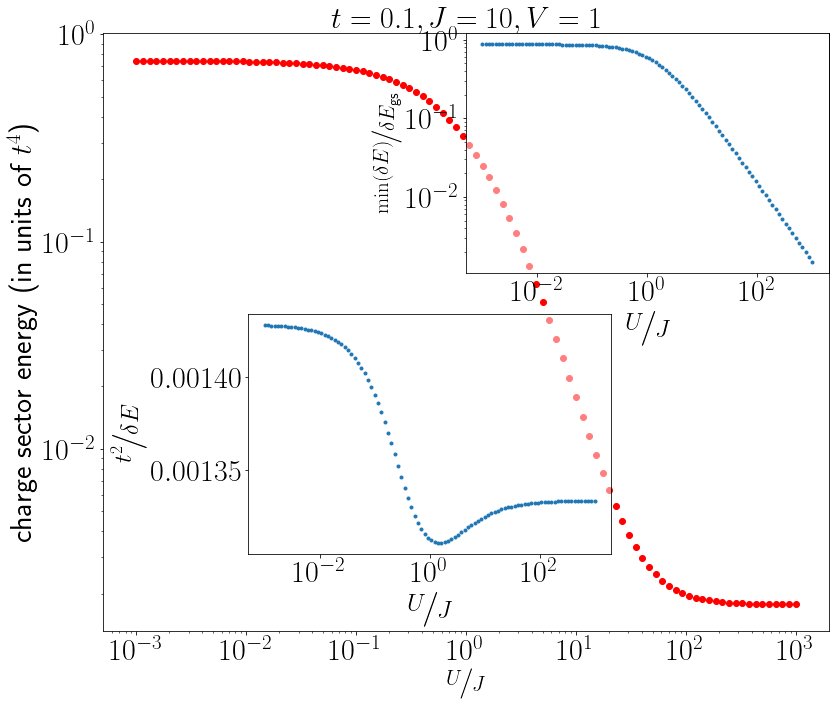

In [641]:
J = 10
V = 1
U_ = 10**np.linspace(-3, 3, 100)*J
J_ = np.ones_like(U_)*J
V_ = np.ones_like(U_)*V
title = r"$t = {}, J={}, V = {}$".format(t, J, V)
ax = plot_all_coeffs(t, U_, V_, J_, U_/J_, r"$\nicefrac{U}{J}$", title, log_in1=False, save="charge_energy_VJt_U.pdf")

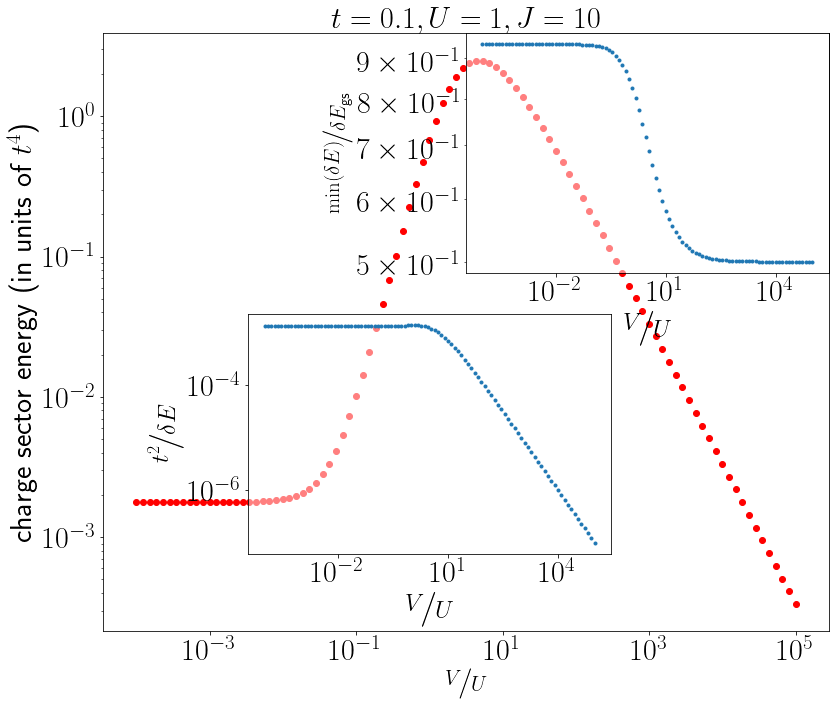

In [640]:
U = 1
J = 10
V_ = 10**np.linspace(-4, 5, 100)*U
J_ = np.ones_like(V_)*J
U_ = np.ones_like(V_)*U
title = r"$t={}, U={}, J = {}$".format(t, U, J)
ax = plot_all_coeffs(t, U_, V_, J_, V_/U_, r"$\nicefrac{V}{U}$", title, save="charge_energy_UVt_J.pdf")

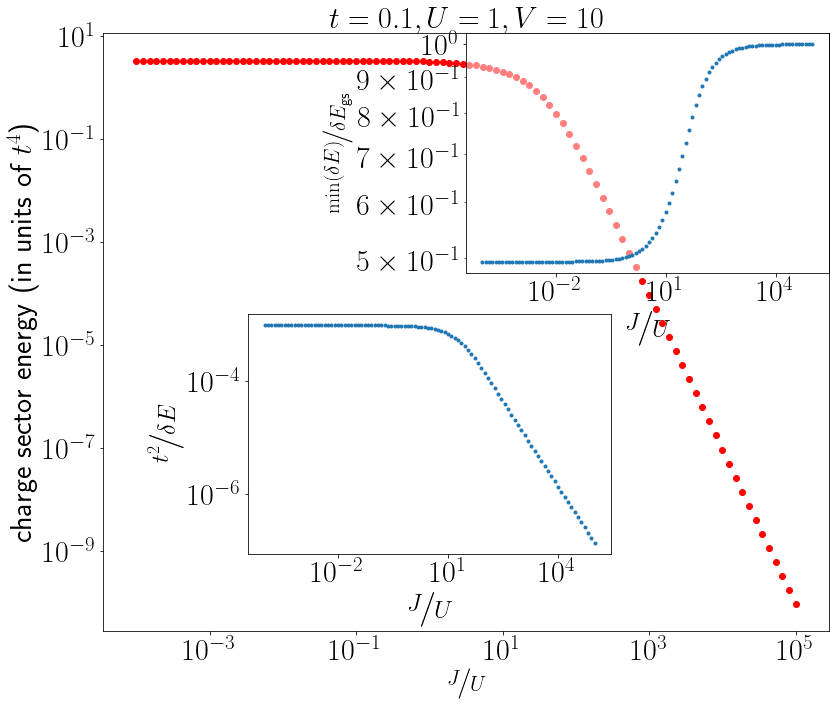

In [642]:
U = 1
V = 10
J_ = 10**np.linspace(-4, 5, 100)*U
V_ = np.ones_like(V_)*V
U_ = np.ones_like(V_)*U
title = r"$t={}, U={}, V={}$".format(t, U, V)
ax = plot_all_coeffs(t, U_, V_, J_, J_/U_, r"$\nicefrac{J}{U}$", title, save="charge_energy_UJt_V.pdf")

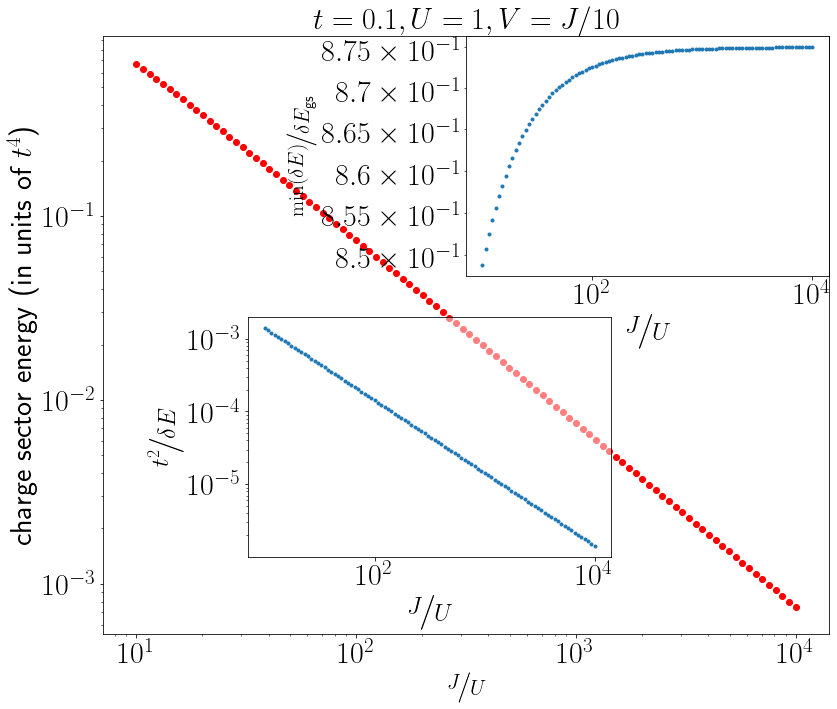

In [649]:
U = 1
J_ = 10**np.linspace(1, 4, 100)*U
V_ = J_/10
U_ = np.ones_like(J_)*U
title = r"$t={}, U={}, V=J/10$".format(t, U)
ax = plot_all_coeffs(t, U_, V_, J_, J_/U_, r"$\nicefrac{J}{U}$", title, save="charge_energy_Ut_VJ.pdf")

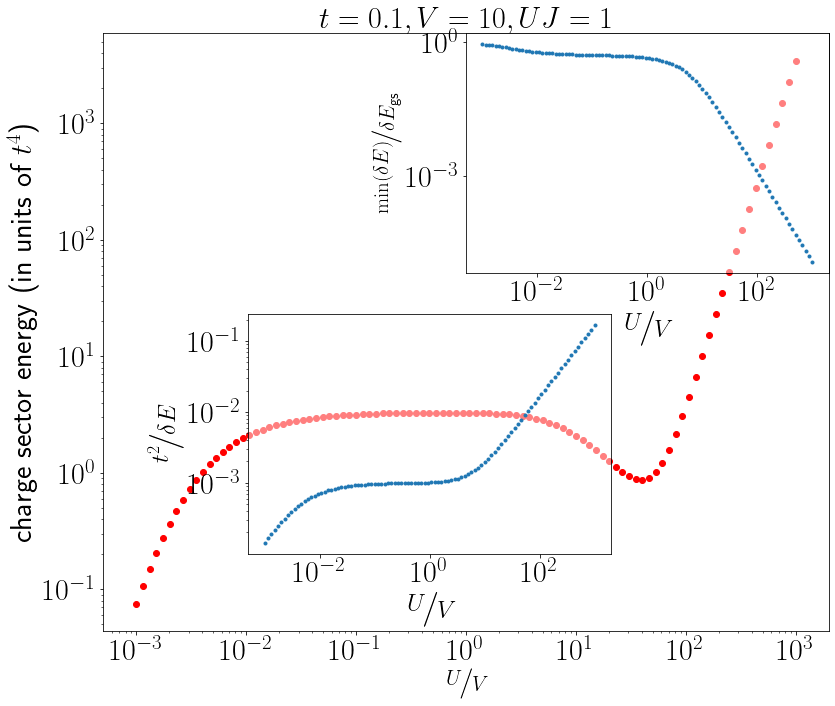

In [650]:
V = 10
U_ = 10**np.linspace(-2, 4, 100)
J_ = 1/U_
V_ = np.ones_like(J_)*V
title = r"$t={}, V={}, UJ=1$".format(t, V)
ax = plot_all_coeffs(t, U_, V_, J_, U_/V_, r"$\nicefrac{U}{V}$", title, save="charge_energy_Vt_UJ.pdf")

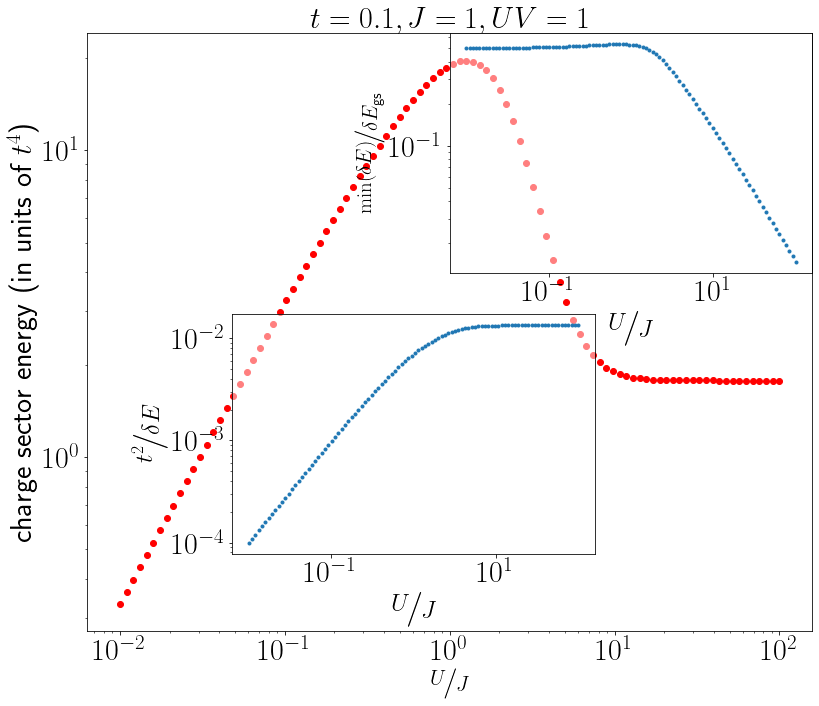

In [651]:
J = 1
U_ = 10**np.linspace(-2, 2, 100)
V_ = 1/U_
J_ = np.ones_like(U_)*J
title = r"$t={}, J={}, UV=1$".format(t, J)
ax = plot_all_coeffs(t, U_, V_, J_, U_/J_, r"$\nicefrac{U}{J}$", title, save="charge_energy_Jt_UV.pdf")